<a href="https://colab.research.google.com/github/1221echo/YL/blob/master/scanpy_tutorial_self_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

--2020-03-29 03:12:07--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.225.103.8, 13.225.103.118, 13.225.103.117, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.225.103.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  5.56MB/s    in 1.3s    

2020-03-29 03:12:10 (5.56 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



In [3]:

!pip install numpy
!pip install scipy
!pip install pandas
!pip install scanpy

     |████████████████████████████████| 7.2MB 1.4MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 


In [0]:
import numpy as np
import pandas as pd
import scanpy as sc

In [0]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)      #Set resolution/size, styling and format of figures.

In [0]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [0]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

In [0]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

I don't understand why use gene_id then it's unnessary

In [10]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

why the var is gene? I think it should be gene_symbols?

In [11]:
help(sc.read_10x_mtx)

Help on function read_10x_mtx in module scanpy.readwrite:

read_10x_mtx(path:Union[pathlib.Path, str], var_names:scanpy._compat.Literal_='gene_symbols', make_unique:bool=True, cache:bool=False, cache_compression:Union[scanpy._compat.Literal_, NoneType, scanpy._utils.Empty]=<Empty.token: 0>, gex_only:bool=True) -> anndata._core.anndata.AnnData
    Read 10x-Genomics-formatted mtx directory.
    
    Parameters
    ----------
    path
        Path to directory for `.mtx` and `.tsv` files,
        e.g. './filtered_gene_bc_matrices/hg19/'.
    var_names
        The variables index.
    make_unique
        Whether to make the variables index unique by appending '-1',
        '-2' etc. or not.
    cache
        If `False`, read from source, if `True`, read from fast 'h5ad' cache.
    cache_compression
        See the h5py :ref:`dataset_compression`.
        (Default: `settings.cache_compression`)
    gex_only
        Only keep 'Gene Expression' data and ignore other feature types,
        e.g

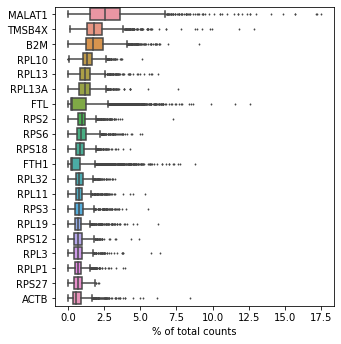

In [12]:
sc.pl.highest_expr_genes(adata,n_top=20) #  Fraction of counts assigned to each gene over all cells.

sc.pl.highest_expr_genes

    Fraction of counts assigned to each gene over all cells.
    
    Computes, for each gene, the fraction of counts assigned to that gene within
    a cell. The `n_top` genes with the highest mean fraction over all cells are
    plotted as boxplots.
    *We expect to see the “usual suspects”, i.e., mitochondrial genes, actin,
    ribosomal protein, MALAT1. A few spike-in transcripts may also be
    present here, though if all of the spike-ins are in the top 50, it
    suggests that too much spike-in RNA was added. A large number of
    pseudo-genes or predicted genes may indicate problems with alignment.*
        -- Davis McCarthy and Aaron Lun

In [0]:
sc.pp.filter_cells(adata, min_genes=200) # Filter cell outliers based on counts and numbers of genes expressed.
sc.pp.filter_genes(adata, min_cells=3) #Filter genes based on number of cells or counts. Minimum number of cells expressed required for a gene to pass filtering.

the reserved cells at least have 200 genese expressed
and the genes left at least expressed in three cells

In [16]:
adata.n_obs

2700

In [0]:
mito_genes = adata.var_names.str.startswith('MT-') # type(mito_genes) numpy.ndarray
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Numpy的主要数据类型是ndarray，即多维数组。它有以下几个属性：

ndarray.ndim：数组的维数
ndarray.shape：数组每一维的大小
ndarray.size：数组中全部元素的数量
ndarray.dtype：数组中元素的类型（numpy.int32, numpy.int16, and numpy.float64等）
ndarray.itemsize：每个元素占几个字节

AnnData 用了一些广义的单词来描述「细胞」和「基因」：将细胞称为观察值 observations ，将基因称为变量 variables

•adata.X 存储 count matrix，数据类型为稀疏矩阵 scipy.sparse.csr.csr_matrix

•adata.obs 存储关于 obervations(cells) 的 metadata，数据类型为 dataframe

adata.var 存储关于 variables(genes) 的 metadata，数据类型为 dataframe



AnnData.uns 存储后续附加的其他非结构化信息

•adata.obs_names 和 adata.var_names index


细胞名和基因名可分别通过 adata.obs_names 和 adata.var_names 查看。 AnnData 对象可以像 dataframe 一样进行切片操作，例如，adata_subset = adata[:, list_of_gene_names]。

In [45]:
print(adata[:,mito_genes].X)

ERROR! Session/line number was not unique in database. History logging moved to new session 60
  (0, 0)	8.0
  (0, 1)	3.0
  (0, 2)	25.0
  (0, 3)	10.0
  (0, 5)	6.0
  (0, 6)	5.0
  (0, 7)	1.0
  (0, 9)	10.0
  (0, 10)	1.0
  (0, 12)	4.0
  (1, 0)	8.0
  (1, 1)	10.0
  (1, 2)	44.0
  (1, 3)	53.0
  (1, 5)	12.0
  (1, 6)	15.0
  (1, 7)	2.0
  (1, 9)	33.0
  (1, 10)	1.0
  (1, 12)	8.0
  (2, 0)	4.0
  (2, 1)	2.0
  (2, 2)	7.0
  (2, 3)	2.0
  (2, 6)	4.0
  :	:
  (2696, 6)	7.0
  (2696, 8)	1.0
  (2696, 9)	2.0
  (2696, 10)	1.0
  (2696, 12)	4.0
  (2697, 1)	2.0
  (2697, 2)	9.0
  (2697, 3)	4.0
  (2697, 5)	4.0
  (2697, 6)	7.0
  (2697, 9)	7.0
  (2697, 12)	4.0
  (2698, 0)	1.0
  (2698, 1)	2.0
  (2698, 2)	12.0
  (2698, 5)	2.0
  (2698, 6)	2.0
  (2698, 8)	1.0
  (2698, 12)	1.0
  (2699, 0)	3.0
  (2699, 1)	1.0
  (2699, 2)	7.0
  (2699, 6)	1.0
  (2699, 9)	1.0
  (2699, 12)	3.0
